In [1]:
!pip install ultralytics




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.2/949.2 kB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [2]:
!git clone https://github.com/Shenggan/BCCD_Dataset.git

Cloning into 'BCCD_Dataset'...
remote: Enumerating objects: 800, done.
remote: Total 800 (delta 0), reused 0 (delta 0), pack-reused 800 (from 1)
Receiving objects: 100% (800/800), 7.39 MiB | 13.15 MiB/s, done.
Resolving deltas: 100% (378/378), done.


In [3]:
import os
import random
import shutil

# Paths

images_path = "/content/BCCD_Dataset/BCCD/JPEGImages"
annotations_path = "/content/BCCD_Dataset/BCCD/Annotations"

# Output directories
output_base = "/content/BCCD_Dataset/BCCD"
splits = ["train", "val", "test"]
for split in splits:
    os.makedirs(os.path.join(output_base, split, "images"), exist_ok=True)
    os.makedirs(os.path.join(output_base, split, "labels"), exist_ok=True)

# Get image files
image_files = [f for f in os.listdir(images_path) if f.endswith(".jpg")]
random.shuffle(image_files)

# Split ratios
train_split = int(0.7 * len(image_files))
val_split = int(0.85 * len(image_files))

# Assign files
train_files = image_files[:train_split]
val_files = image_files[train_split:val_split]
test_files = image_files[val_split:]

# Function to move images and annotations
def move_files(file_list, split):
    for file in file_list:
        # Move image
        shutil.copy(os.path.join(images_path, file), os.path.join(output_base, split, "images", file))

        # Move annotation
        xml_file = file.replace(".jpg", ".xml")
        if os.path.exists(os.path.join(annotations_path, xml_file)):
            shutil.copy(os.path.join(annotations_path, xml_file), os.path.join(output_base, split, "labels", xml_file))

# Move the files
move_files(train_files, "train")
move_files(val_files, "val")
move_files(test_files, "test")

print("✅ Dataset split completed!")


✅ Dataset split completed!


In [4]:
import os
import xml.etree.ElementTree as ET

# Class mapping
class_mapping = {"RBC": 0, "WBC": 1, "Platelet": 2}

# Paths
dataset_dir = "/content/BCCD_Dataset/BCCD"
splits = ["train", "val", "test"]

# Convert XML to YOLO format
def convert_to_yolo(xml_file, output_txt_file, image_width, image_height):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    with open(output_txt_file, "w") as txt_file:
        for obj in root.findall("object"):
            class_name = obj.find("name").text
            if class_name not in class_mapping:
                continue

            class_id = class_mapping[class_name]
            bbox = obj.find("bndbox")
            xmin = int(bbox.find("xmin").text)
            ymin = int(bbox.find("ymin").text)
            xmax = int(bbox.find("xmax").text)
            ymax = int(bbox.find("ymax").text)

            # Normalize
            x_center = (xmin + xmax) / (2.0 * image_width)
            y_center = (ymin + ymax) / (2.0 * image_height)
            width = (xmax - xmin) / image_width
            height = (ymax - ymin) / image_height

            # Write in YOLO format
            txt_file.write(f"{class_id} {x_center} {y_center} {width} {height}\n")

# Process each split
for split in splits:
    labels_dir = os.path.join(dataset_dir, split, "labels")
    images_dir = os.path.join(dataset_dir, split, "images")

    for xml_file in os.listdir(labels_dir):
        if xml_file.endswith(".xml"):
            tree = ET.parse(os.path.join(labels_dir, xml_file))
            root = tree.getroot()
            image_width = int(root.find("size/width").text)
            image_height = int(root.find("size/height").text)

            # Convert and save as .txt
            txt_file = os.path.join(labels_dir, xml_file.replace(".xml", ".txt"))
            convert_to_yolo(os.path.join(labels_dir, xml_file), txt_file, image_width, image_height)

            # Remove XML after conversion
            os.remove(os.path.join(labels_dir, xml_file))

print("✅ Annotations converted to YOLO format!")


✅ Annotations converted to YOLO format!


In [9]:
from ultralytics import YOLO

# Load YOLOv10 model
model = YOLO("yolov10n.pt")  # Use "yolov10s.pt" for larger model




In [11]:
from ultralytics import YOLO

# Load YOLOv10 model
model = YOLO("yolov10n.pt")  # Use "yolov10s.pt" for larger model

# Train the model
model.train(data="/content/BCCD_Dataset/BCCD/bccd1.yaml", epochs=50, imgsz=640, batch=16)


Ultralytics 8.3.91 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov10n.pt, data=/content/BCCD_Dataset/BCCD/bccd1.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=Tru

100%|██████████| 755k/755k [00:00<00:00, 23.9MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1      9856  ultralytics.nn.modules.block.SCDown          [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1     36096  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 75.4MB/s]


AMP: checks passed ✅


train: Scanning /content/BCCD_Dataset/BCCD/train/labels... 254 images, 1 backgrounds, 0 corrupt: 100%|██████████| 254/254 [00:00<00:00, 2140.33it/s]

train: New cache created: /content/BCCD_Dataset/BCCD/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/BCCD_Dataset/BCCD/val/labels... 55 images, 0 backgrounds, 0 corrupt: 100%|██████████| 55/55 [00:00<00:00, 428.80it/s]

val: New cache created: /content/BCCD_Dataset/BCCD/val/labels.cache


Plotting labels to runs/detect/train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.0005), 107 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train5
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      3.14G      2.621      6.862       2.84        325        640: 100%|██████████| 16/16 [00:07<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]

                   all         55        688     0.0305      0.862       0.22       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      3.17G      2.405      4.783      2.381        341        640: 100%|██████████| 16/16 [00:05<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.62it/s]

                   all         55        688     0.0327      0.947      0.558      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      3.18G      2.454      3.601      2.395        254        640: 100%|██████████| 16/16 [00:04<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.37it/s]

                   all         55        688     0.0326       0.96      0.492      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50       3.2G      2.352      3.019      2.384        278        640: 100%|██████████| 16/16 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.75it/s]

                   all         55        688     0.0464      0.973      0.625      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      3.35G       2.25      2.723      2.336        328        640: 100%|██████████| 16/16 [00:05<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.44it/s]

                   all         55        688      0.826      0.179      0.611      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      3.36G      2.301      2.658      2.398        250        640: 100%|██████████| 16/16 [00:05<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.14it/s]

                   all         55        688      0.795      0.329      0.693      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      3.51G      2.313      2.534      2.348        285        640: 100%|██████████| 16/16 [00:05<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.20it/s]

                   all         55        688      0.813      0.769      0.849      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      3.53G      2.259      2.399      2.348        293        640: 100%|██████████| 16/16 [00:06<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.55it/s]

                   all         55        688      0.742      0.749       0.83      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      3.54G      2.261      2.298      2.336        304        640: 100%|██████████| 16/16 [00:04<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.77it/s]

                   all         55        688       0.75      0.799      0.833      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      3.56G      2.164      2.231      2.279        281        640: 100%|██████████| 16/16 [00:04<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.88it/s]

                   all         55        688      0.722      0.798      0.852      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.58G      2.203      2.157      2.295        415        640: 100%|██████████| 16/16 [00:05<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.30it/s]

                   all         55        688      0.826      0.746       0.87      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      3.59G      2.199        2.1      2.294        288        640: 100%|██████████| 16/16 [00:04<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.70it/s]

                   all         55        688        0.8      0.879      0.887      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.61G      2.182      2.078      2.284        376        640: 100%|██████████| 16/16 [00:05<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.68it/s]

                   all         55        688      0.779      0.822      0.875      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.62G      2.129      2.081      2.242        407        640: 100%|██████████| 16/16 [00:04<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.28it/s]

                   all         55        688      0.819      0.882      0.896      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      3.64G      2.145      2.019      2.263        241        640: 100%|██████████| 16/16 [00:05<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.78it/s]

                   all         55        688      0.842      0.881      0.901       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.65G      2.108      2.001      2.275        260        640: 100%|██████████| 16/16 [00:04<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.74it/s]


                   all         55        688      0.804      0.877      0.905      0.687

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      3.67G      2.137      1.934      2.239        285        640: 100%|██████████| 16/16 [00:05<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.83it/s]

                   all         55        688      0.842      0.877      0.908      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.69G      2.151       1.93       2.25        335        640: 100%|██████████| 16/16 [00:04<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.80it/s]

                   all         55        688       0.84      0.862      0.911      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50       3.7G      2.127      1.924      2.264        241        640: 100%|██████████| 16/16 [00:05<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.71it/s]

                   all         55        688      0.835      0.875      0.911      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      3.71G      2.122      1.914      2.267        328        640: 100%|██████████| 16/16 [00:04<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.59it/s]

                   all         55        688       0.83      0.844      0.898      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      3.73G      2.068      1.886      2.249        301        640: 100%|██████████| 16/16 [00:05<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.91it/s]

                   all         55        688      0.828      0.911      0.914       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.75G      2.086      1.864      2.238        325        640: 100%|██████████| 16/16 [00:04<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]

                   all         55        688      0.813      0.848       0.87      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.76G       2.08      1.937      2.278        331        640: 100%|██████████| 16/16 [00:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.48it/s]

                   all         55        688      0.811      0.837      0.907      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      3.78G      2.048      1.813       2.23        265        640: 100%|██████████| 16/16 [00:04<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.41it/s]

                   all         55        688      0.788      0.901      0.911      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      3.79G       2.08      1.738      2.259        297        640: 100%|██████████| 16/16 [00:05<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.87it/s]

                   all         55        688      0.834      0.889      0.913      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      3.81G      2.057      1.749      2.217        320        640: 100%|██████████| 16/16 [00:04<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.88it/s]

                   all         55        688      0.826      0.859      0.909      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.82G      2.062      1.733       2.24        429        640: 100%|██████████| 16/16 [00:04<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]

                   all         55        688      0.837      0.877      0.915      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.84G      2.047      1.679      2.201        293        640: 100%|██████████| 16/16 [00:05<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.61it/s]


                   all         55        688      0.797      0.894      0.912      0.704

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.86G      2.006      1.644       2.19        260        640: 100%|██████████| 16/16 [00:04<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.69it/s]

                   all         55        688      0.886      0.822      0.921        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.87G      1.985      1.659        2.2        280        640: 100%|██████████| 16/16 [00:05<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.90it/s]

                   all         55        688      0.878        0.8      0.908      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.89G      1.997      1.591      2.213        365        640: 100%|██████████| 16/16 [00:04<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.57it/s]

                   all         55        688      0.876      0.858      0.916      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50       3.9G      1.978      1.564      2.188        292        640: 100%|██████████| 16/16 [00:05<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.74it/s]

                   all         55        688      0.829      0.887       0.92      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.92G      2.004      1.612      2.227        254        640: 100%|██████████| 16/16 [00:04<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.57it/s]

                   all         55        688      0.856      0.856      0.915      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.07G      1.996      1.612      2.182        354        640: 100%|██████████| 16/16 [00:05<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.84it/s]

                   all         55        688      0.849      0.876      0.921      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      4.09G      1.957      1.599      2.194        262        640: 100%|██████████| 16/16 [00:04<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.84it/s]

                   all         55        688      0.865      0.869      0.921      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50       4.1G       1.97      1.583      2.178        406        640: 100%|██████████| 16/16 [00:04<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

                   all         55        688      0.866      0.858      0.911      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      4.12G      1.895      1.494      2.138        301        640: 100%|██████████| 16/16 [00:04<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.86it/s]

                   all         55        688      0.871      0.885      0.933       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.13G      1.924       1.48      2.175        324        640: 100%|██████████| 16/16 [00:04<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.63it/s]

                   all         55        688      0.861      0.893      0.925      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.15G      1.917      1.458      2.158        265        640: 100%|██████████| 16/16 [00:05<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.93it/s]

                   all         55        688      0.861      0.889      0.925      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      4.16G       1.92      1.484      2.154        310        640: 100%|██████████| 16/16 [00:04<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.81it/s]


                   all         55        688      0.891      0.889      0.928      0.715
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      4.18G      1.917      1.678      2.199        188        640: 100%|██████████| 16/16 [00:07<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.86it/s]

                   all         55        688      0.874      0.849      0.917      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      4.19G      1.855      1.547      2.179        153        640: 100%|██████████| 16/16 [00:04<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.77it/s]

                   all         55        688       0.84      0.913      0.927      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.21G      1.864      1.465      2.154        165        640: 100%|██████████| 16/16 [00:05<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.67it/s]

                   all         55        688      0.852      0.912      0.923      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.22G      1.843      1.432      2.155        175        640: 100%|██████████| 16/16 [00:04<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.81it/s]

                   all         55        688      0.905       0.87      0.936      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.24G      1.822      1.414      2.164        154        640: 100%|██████████| 16/16 [00:05<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.69it/s]

                   all         55        688      0.914      0.867      0.938      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.26G      1.785      1.374      2.138        132        640: 100%|██████████| 16/16 [00:04<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.90it/s]

                   all         55        688      0.896      0.885      0.937      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      4.27G      1.776      1.326      2.111        160        640: 100%|██████████| 16/16 [00:04<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.07it/s]

                   all         55        688      0.878       0.89      0.935      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      4.29G      1.778      1.354      2.158        167        640: 100%|██████████| 16/16 [00:04<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.71it/s]

                   all         55        688      0.883      0.901      0.936       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50       4.3G      1.745       1.32      2.097        178        640: 100%|██████████| 16/16 [00:04<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.02it/s]

                   all         55        688        0.9      0.878      0.934       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.31G       1.74       1.28      2.126        156        640: 100%|██████████| 16/16 [00:05<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.05it/s]

                   all         55        688      0.914      0.874      0.935      0.722



50 epochs completed in 0.096 hours.
Optimizer stripped from runs/detect/train5/weights/last.pt, 5.7MB
Optimizer stripped from runs/detect/train5/weights/best.pt, 5.7MB

Validating runs/detect/train5/weights/best.pt...
Ultralytics 8.3.91 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10n summary (fused): 125 layers, 2,695,586 parameters, 0 gradients, 8.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.77it/s]


                   all         55        688      0.913      0.865      0.938      0.734
                   RBC         54        631      0.849      0.729      0.881      0.639
                   WBC         55         57      0.978          1      0.995      0.829
Speed: 0.2ms preprocess, 1.9ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/detect/train5


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f084d4e9750>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [13]:
results = model.predict("/content/BCCD_Dataset/BCCD/test/images/BloodImage_00021.jpg", conf=0.25)
for r in results:
    print(r.boxes.xyxy)  # Bounding box coordinates (x_min, y_min, x_max, y_max)
    print(r.boxes.cls)    # Class IDs (0 = RBC, 1 = WBC, 2 = Platelet)
    print(r.boxes.conf)   # Confidence scores



image 1/1 /content/BCCD_Dataset/BCCD/test/images/BloodImage_00021.jpg: 480x640 16 RBCs, 1 WBC, 45.8ms
Speed: 2.1ms preprocess, 45.8ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)
tensor([[3.3581e+02, 3.0404e+02, 4.7489e+02, 4.4074e+02],
        [8.2274e-01, 1.0463e+02, 1.0433e+02, 2.0429e+02],
        [9.3938e+01, 3.3775e+02, 2.1472e+02, 4.5889e+02],
        [2.0709e+02, 0.0000e+00, 3.2191e+02, 1.1175e+02],
        [3.6517e+02, 1.4259e+02, 4.8442e+02, 2.4942e+02],
        [5.1786e+02, 1.0709e+02, 6.2576e+02, 2.1023e+02],
        [5.7615e+02, 3.5438e+02, 6.3993e+02, 4.6344e+02],
        [2.7864e+02, 1.6370e+02, 3.9820e+02, 2.7334e+02],
        [1.5048e+02, 2.4169e+02, 2.5348e+02, 3.3074e+02],
        [4.5650e+02, 3.7388e+02, 5.7580e+02, 4.7080e+02],
        [6.9921e+01, 9.4100e+01, 1.7415e+02, 1.9765e+02],
        [2.7937e+02, 1.6276e+02, 3.9731e+02, 2.7373e+02],
        [4.6029e+02, 3.7308e+02, 5.7485e+02, 4.6620e+02],
        [3.8226e+02, 1.4740e-01, 4.9536e+02, 9


image 1/1 /content/BCCD_Dataset/BCCD/test/images/BloodImage_00035.jpg: 480x640 29 RBCs, 1 WBC, 30.2ms
Speed: 2.5ms preprocess, 30.2ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


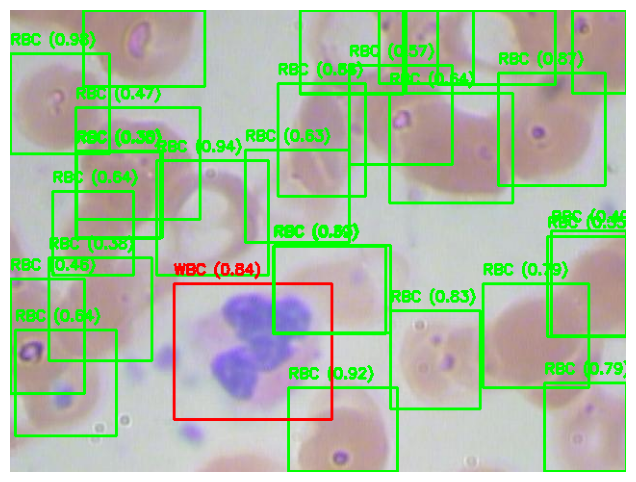

In [15]:
from PIL import Image
import cv2
import torch
import matplotlib.pyplot as plt

# Load the image
image_path = "/content/BCCD_Dataset/BCCD/test/images/BloodImage_00035.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Get results from YOLO
results = model.predict(image_path, conf=0.25)

# Draw Bounding Boxes
for r in results:
    boxes = r.boxes.xyxy.cpu().numpy()  # Convert to NumPy
    classes = r.boxes.cls.cpu().numpy()
    confidences = r.boxes.conf.cpu().numpy()

    for i, (box, cls, conf) in enumerate(zip(boxes, classes, confidences)):
        x_min, y_min, x_max, y_max = map(int, box)
        label = f"{r.names[int(cls)]} ({conf:.2f})"

        # Choose color for different classes
        color = (0, 255, 0) if int(cls) == 0 else (255, 0, 0) if int(cls) == 1 else (0, 0, 255)

        # Draw bounding box
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, 2)

        # Draw label text
        cv2.putText(image, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

# Show the image with detections
plt.figure(figsize=(10, 6))
plt.imshow(image)
plt.axis("off")
plt.show()


In [ ]:
from google.colab import drive
import shutil

# Mount Google Drive
drive.mount('/content/drive')

# Copy trained model to Google Drive
shutil.copy("runs/detect/train/weights/best.pt", "/content/drive/MyDrive/best_yolov10.pt")

print("✅ Model saved to Google Drive!")
